# VENDEE GLOBE  

_C'est pas l'homme qui prend la mer, c'est la mer qui prend l'homme, TINTINTIN_ - un anonyme homonyme d'un constructeur automobile national  

Aujourd'hui nous allons nous poser une question similaire : est-ce le marin qui porte le bateau, ou le bateau qui porte le marin ?

En utilisant les données du classement du Vendée Globe de l'an passé, ainsi que les données liées aux navires de ces marins, nous tenterons de voir dans quelle mesure les caractéristiques des vaisseaux ont affecté la performance des participants.

# OBTENTION DES DONNEES

In [ ]:
"""from datetime import datetime,timedelta
import requests
import random

date = datetime.strptime("20201108",'%Y%m%d').date()
final_date = datetime.strptime("20210305",'%Y%m%d').date()
addoneday = timedelta(days=1)

times = list()
for time in ["04", "08", "11", "14", "17", "21"]: 
    times.append(datetime.strptime(time,"%H").time())

while date <= final_date:
    for time in times:
        x = datetime.combine(date, time).strftime('%Y%m%d_%H%M%S')
        url = f"https://www.vendeeglobe.org/download-race-data/vendeeglobe_{x}.xlsx"
        try:
            r = requests.get(url, allow_redirects=True)
            if r.status_code==200:
                open(f"data/{x}.xlsx", "wb").write(r.content)
        except:
            continue
    date += addoneday"""

In [ ]:
"""import glob
import xlwings

def xlsx_broken(file):
    excel_app = xlwings.App(visible=False)
    excel_book = excel_app.books.open(file)
    excel_book.save()
    excel_book.close()
    excel_app.quit()
    return True

for f in glob.glob("./data/*"):
    xlsx_broken(f)"""

# NETTOYAGE ET SCRAPING DES DONNEES DES BATEAUX

In [1]:
import pandas as pd
import re
import numpy as np
import glob
from datetime import datetime
import os
import requests
from bs4 import BeautifulSoup

pd.options.display.max_columns=25

#https://stackoverflow.com/questions/33997361
def dms2dd(s):
    try:
        degrees, minutes, direction = re.split('[°\'"]+', s)
        dd = float(degrees) + float(minutes)/60
        if direction in ('S','W'):
            dd*= -1
        return dd
    except:
        return s

def opendf(file):
    df = pd.read_excel(file, header=[0,1], skiprows=3, nrows=33)
    df = df.dropna(axis=1, how="all")
    df.columns = [re.sub(r'\W+', '', \
                  ' '.join([x.split("\n")[0] if x.split("\n")[0] and "Unnamed" not in x else "" if "Unnamed" in x else x for x in y]) \
                  .strip()) \
                  for y in df.columns.values]
    df[["Nat", "Voile"]] = df["NatVoile"].str.split(" ", expand=True)
    df["Nat"] = df["Nat"].str.split("\n").apply(lambda x: x[1] if isinstance(x,list) else x) #Sacrée Armel
    df[["Skipper", "Bateau"]] = df["SkipperBateau"].str.split("\n", expand=True)
    df["Bateau"] = df["Bateau"].str.lower() #Hugo Boss s'énerve à mi-chemin
    df["SkipperBateauHeureFR"] = df["SkipperBateauHeureFR"].str.split(" ").apply(lambda x: x[0] if isinstance(x,list) else x)
    for col in df.columns:
        df[col] = df[col].str.strip()
    df["Voile"] = df["Voile"].astype(int)
    df["DateTime"] = datetime.strptime(os.path.basename(file).split(".")[-2].split("/")[-1], '%Y%m%d_%H%M%S')
    splitto = lambda x: x.split()[0] if isinstance(x,str) else x
    df["DTF_nm"] = df["DTF"].apply(splitto).astype(float)
    df["DTL_nm"] = df["DTL"].apply(splitto).astype(float)
    df["24h_dist_nm"] = df["Depuis24heuresDistance"].apply(splitto).astype(float)
    df["24h_vitesse_kts"] = df["Depuis24heuresVitesse"].apply(splitto).astype(float)
    df["24h_vmg_kts"] = df["Depuis24heuresVMG"].apply(splitto).astype(float)
    df["classement_dist_nm"] = df["DepuisledernierclassementDistance"].apply(splitto).astype(float)
    df["classement_vitesse_kts"] = df["DepuisledernierclassementVitesse"].apply(splitto).astype(float)
    df["classement_vmg_kts"] = df["DepuisledernierclassementVMG"].apply(splitto).astype(float)
    df["30min_dist_nm"] = df["Depuis30minutesDistance"].apply(splitto).astype(float)
    df["30min_vitesse_kts"] = df["Depuis30minutesVitesse"].apply(splitto).astype(float)
    df["30min_vmg_kts"] = df["Depuis30minutesVMG"].apply(splitto).astype(float)
    df["Latitude"] = df["SkipperBateauLatitude"].apply(dms2dd)
    df["Longitude"] = df["SkipperBateauLongitude"].apply(dms2dd)
    dropcols = ["DTF","DTL","Depuis24heuresDistance","Depuis24heuresVitesse","Depuis24heuresVMG",
                "Depuis30minutesDistance","Depuis30minutesVitesse","Depuis30minutesVMG",
                "DepuisledernierclassementDistance","DepuisledernierclassementVitesse","DepuisledernierclassementVMG",
                "SkipperBateauLatitude","SkipperBateauLongitude","SkipperBateau","NatVoile"]
    df = df.drop(dropcols, axis=1)
    return df

df = opendf("./data/20201108_140000.xlsx")
for f in glob.glob("./data/*"):
    try:
        df = df.append(opendf(f))
    except:
        continue

df.to_csv("./dataclean/vendeeglobe0.csv")

df.head()

,Rang,SkipperBateauHeureFR,Depuis30minutesCap,DepuisledernierclassementCap,Depuis24heuresCap,Nat,Voile,Skipper,Bateau,DateTime,DTF_nm,DTL_nm,24h_dist_nm,24h_vitesse_kts,24h_vmg_kts,classement_dist_nm,classement_vitesse_kts,classement_vmg_kts,30min_dist_nm,30min_vitesse_kts,30min_vmg_kts,Latitude,Longitude
0,1,15:30,241°,357°,201°,FRA,18,Louis Burton,bureau vallée 2,2020-11-08 14:00:00,24293.9,0.0,6.1,0.3,0.3,2788.0,0.0,0.0,0.3,17.7,17.5,46.407667,-1.841333
1,2,15:31,241°,357°,196°,MON,10,Boris Herrmann,seaexplorer - yacht club de monaco,2020-11-08 14:00:00,24294.2,0.4,6.0,0.3,0.2,2787.9,0.0,0.0,0.4,11.1,10.9,46.405667,-1.830333
2,3,15:30,244°,357°,199°,FRA,8,Jérémie Beyou,charal,2020-11-08 14:00:00,24294.3,0.5,5.5,0.2,0.2,2788.5,0.0,0.0,0.5,15.5,15.5,46.415167,-1.833167
3,4,15:30,244°,357°,196°,FRA,59,Thomas Ruyant,linkedout,2020-11-08 14:00:00,24294.5,0.6,5.6,0.2,0.2,2788.3,0.0,0.0,0.7,13.2,13.1,46.411833,-1.828000
4,5,15:30,246°,357°,195°,FRA,53,Maxime Sorel,v and b mayenne,2020-11-08 14:00:00,24294.5,0.6,5.8,0.8,0.7,2788.1,0.0,0.0,0.2,10.9,10.9,46.409833,-1.826000


In [2]:
soup = BeautifulSoup(requests.get("https://www.vendeeglobe.org/fr/glossaire").content.decode("utf-8"))

boats=list()
for boat in soup.find_all("div", {"class":"boats-list__popup-infos"}):
    dict_ = {"nom":boat.find("h3").text}
    for li in boat.find_all("li")[:-1]:
        dict_[li.text.split(":")[0].strip()] = li.text.split(":")[1].strip()
    boats.append(dict_)

df_boats = pd.DataFrame(boats)
for col in df_boats.columns:
    df_boats[col] = df_boats[col].str.lower()

dict_ = {"foiler":"foils","2":"no foils","2 asymétriques":"no foils","foils":"foils"}
df_boats["Foils"] = df_boats["Nombre de dérives"].map(dict_)
df_boats = df_boats.drop("Nombre de dérives",1)

df_boats["Voile quille"] = df_boats["Voile quille"].apply(lambda x: x.split()[0] if isinstance(x,str) else x)

df_boats["Numéro de voile"] = df_boats["Numéro de voile"].fillna(59) #valeur manquante dans le glossaire, on remplit d'après les excel

df_boats["Year_launched"] = df_boats["Date de lancement"].apply(lambda x: x[-4:])
df_boats["Year_launched"] = pd.to_datetime(df_boats["Year_launched"], format="%Y").dt.year
df_boats = df_boats.drop("Date de lancement",1)

numcols = ["Numéro de voile","Tirant d'eau","Déplacement (poids)","Longueur","Largeur","Surface de voiles au près", "Hauteur mât"]

for col in numcols:
    df_boats[col] = df_boats[col].apply(lambda x: re.sub("[a-z]+", "", str(x).lower()).strip().replace(",","."))

df_boats["Numéro de voile"] = df_boats["Numéro de voile"].astype(int).replace(16,10).replace(77,777) #on remplace d'après les excels

df_boats["Déplacement (poids)"] = df_boats["Déplacement (poids)"].apply(lambda x: np.nan if x == "" else x)
df_boats["Surface de voiles au près"] = df_boats["Surface de voiles au près"].apply(lambda x: x.split()[0])
df_boats[numcols] = df_boats[numcols].astype(float)

df_boats.to_csv("./dataclean/boats.csv")

df_boats.head()

,nom,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Hauteur mât,Voile quille,Surface de voiles au près,Foils,Year_launched
0,newrest - art & fenêtres,56.0,"no way back, vento di sardegna",vplp/verdier,persico marine,18.28,5.85,4.5,7.0,29.0,monotype,320.0,foils,2015
1,pure - best western®,49.0,"gitana eighty, synerciel, newrest-matmut",bruce farr design,southern ocean marine (nouvelle zélande),18.28,5.80,4.5,9.0,28.0,acier,280.0,no foils,2007
2,tse - 4myplanet,72.0,"famille mary-etamine du lys, initiatives coeur...",marc lombard,mag france,18.28,5.54,4.5,9.0,29.0,acier,260.0,no foils,1998
3,maître coq iv,17.0,safran 2 - des voiles et vous,verdier - vplp,cdk technologies,18.28,5.80,4.5,8.0,29.0,acier,310.0,foils,2015
4,charal,8.0,NaN,vplp,cdk technologies,18.28,5.85,4.5,8.0,29.0,acier,320.0,foils,2018


In [3]:
df["Date"] = df["DateTime"].dt.date #pour grouper et prendre la dernière
df["DateTime"] = df["DateTime"].astype(str) #plotly préfère les strings 
df = df[df["Rang"].str.isnumeric()] #élimination des skippers éliminés ou ayant abandonné
df["Rang"] = df["Rang"].astype(int) #pour visualisations

df_merged = df.merge(df_boats, left_on="Voile", right_on="Numéro de voile", how="left")
df_merged.to_csv("./dataclean/vendeewboats.csv")

df_merged.head()

,Rang,SkipperBateauHeureFR,Depuis30minutesCap,DepuisledernierclassementCap,Depuis24heuresCap,Nat,Voile,Skipper,Bateau,DateTime,DTF_nm,DTL_nm,...,Anciens noms du bateau,Architecte,Chantier,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Hauteur mât,Voile quille,Surface de voiles au près,Foils,Year_launched
0,1,15:30,241°,357°,201°,FRA,18,Louis Burton,bureau vallée 2,2020-11-08 14:00:00,24293.9,0.0,...,banque populaire viii,verdier - vplp,cdk technologies,18.28,5.80,4.5,7.6,28.0,acier,300.0,foils,2015
1,2,15:31,241°,357°,196°,MON,10,Boris Herrmann,seaexplorer - yacht club de monaco,2020-11-08 14:00:00,24294.2,0.4,...,"edmond de rothschild, malizia - yacht club de ...",verdier - vplp,multiplast,18.28,5.70,4.5,7.6,29.0,acier,290.0,foils,2015
2,3,15:30,244°,357°,199°,FRA,8,Jérémie Beyou,charal,2020-11-08 14:00:00,24294.3,0.5,...,NaN,vplp,cdk technologies,18.28,5.85,4.5,8.0,29.0,acier,320.0,foils,2018
3,4,15:30,244°,357°,196°,FRA,59,Thomas Ruyant,linkedout,2020-11-08 14:00:00,24294.5,0.6,...,NaN,verdier,persico,18.28,5.85,4.5,8.0,29.0,acier,350.0,foils,2019
4,5,15:30,246°,357°,195°,FRA,53,Maxime Sorel,v and b mayenne,2020-11-08 14:00:00,24294.5,0.6,...,"le souffle du nord, groupe bel",verdier - vplp,"indiana yachting (scarlino, italie)",18.28,5.50,4.5,7.7,29.0,acier,365.0,no foils,2007


# VISUALISATIONS

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import plot
import plotly.io as pio
pio.renderers.default = "vscode"

df_grouped = df.groupby(["Date","Bateau"]).last()
df_grouped["Voile"] = df_grouped["Voile"].astype(str)
df_grouped.head()

ImportError: cannot import name 'animation' from partially initialized module 'matplotlib' (most likely due to a circular import) (C:\Users\phile\anaconda3\lib\site-packages\matplotlib\__init__.py)

## Les figures plotly sont enregistrées au format html dans le dossier "plots" et disponibles directement sous ce format

In [33]:
fig = px.scatter_geo(df_grouped, lat="Latitude", lon="Longitude", color="Voile", animation_frame="DateTime")
fig.write_html("plots/flat_animation.html")
plot(fig)

'temp-plot.html'

In [34]:
fig = px.scatter_geo(df_grouped, lat="Latitude", lon="Longitude", color="Voile", projection="orthographic", animation_frame="DateTime")
fig.write_html("plots/globe_animation.html")
plot(fig)

'temp-plot.html'

In [40]:
fig = px.line_geo(df_grouped, lat="Latitude", lon="Longitude", color="Voile")
fig.write_html("plots/flat_line.html")
fig.show()

In [41]:
fig = px.line_geo(df_grouped, lat="Latitude", lon="Longitude", color="Voile", projection="orthographic")
fig.write_html("plots/globe_line.html")
fig.show()

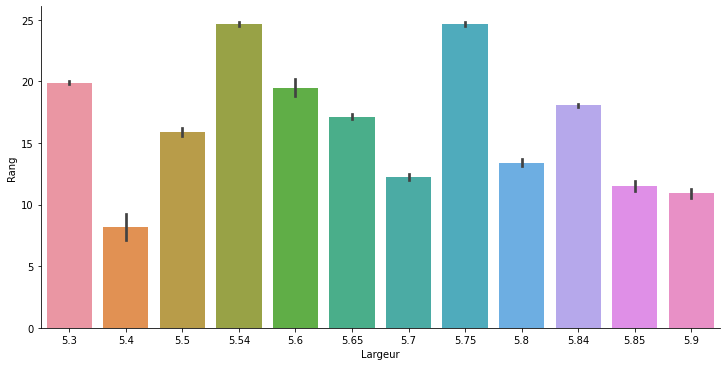

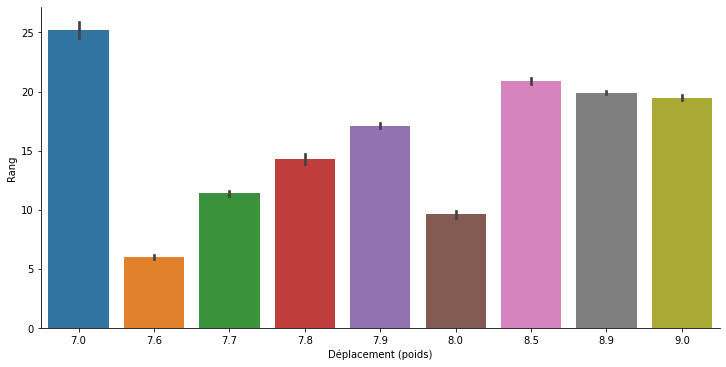

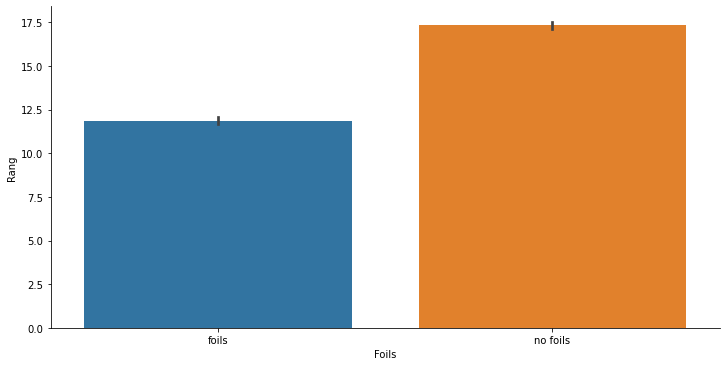

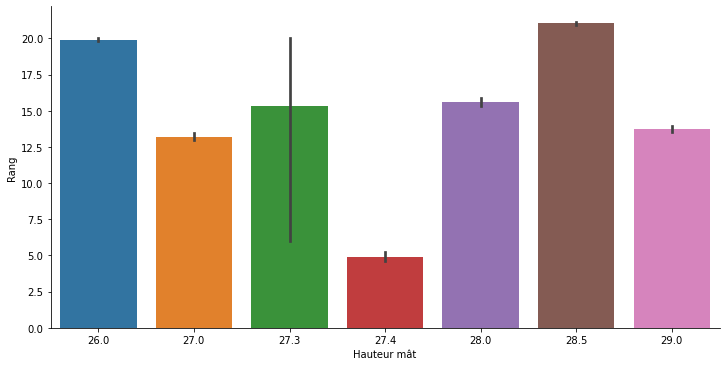

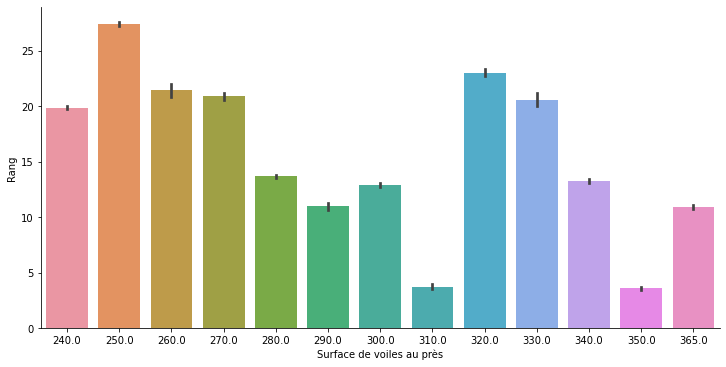

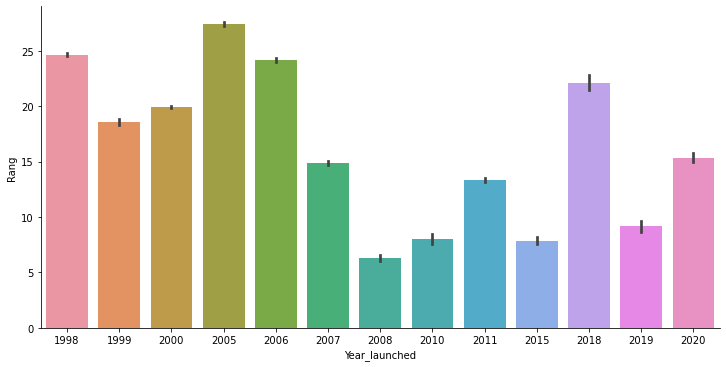

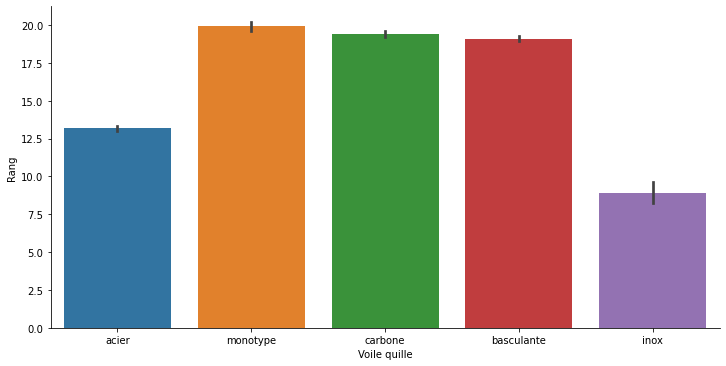

In [36]:
for col in ["Largeur","Déplacement (poids)","Foils","Hauteur mât","Surface de voiles au près","Year_launched","Voile quille"]:
    sns.catplot(data=df_merged, x=col, y="Rang", kind="bar", aspect=2, ci=None)
    plt.show()

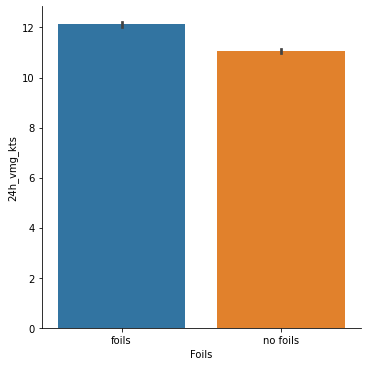

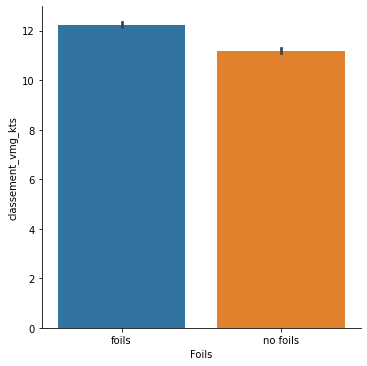

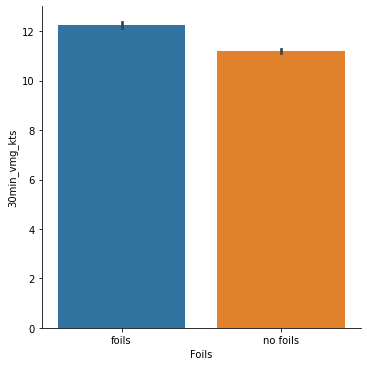

In [37]:
for col in [x for x in df_merged.columns if "vmg" in x]:
    sns.catplot(data=df_merged, x="Foils", y=col, kind="bar", ci=None)
    plt.show()

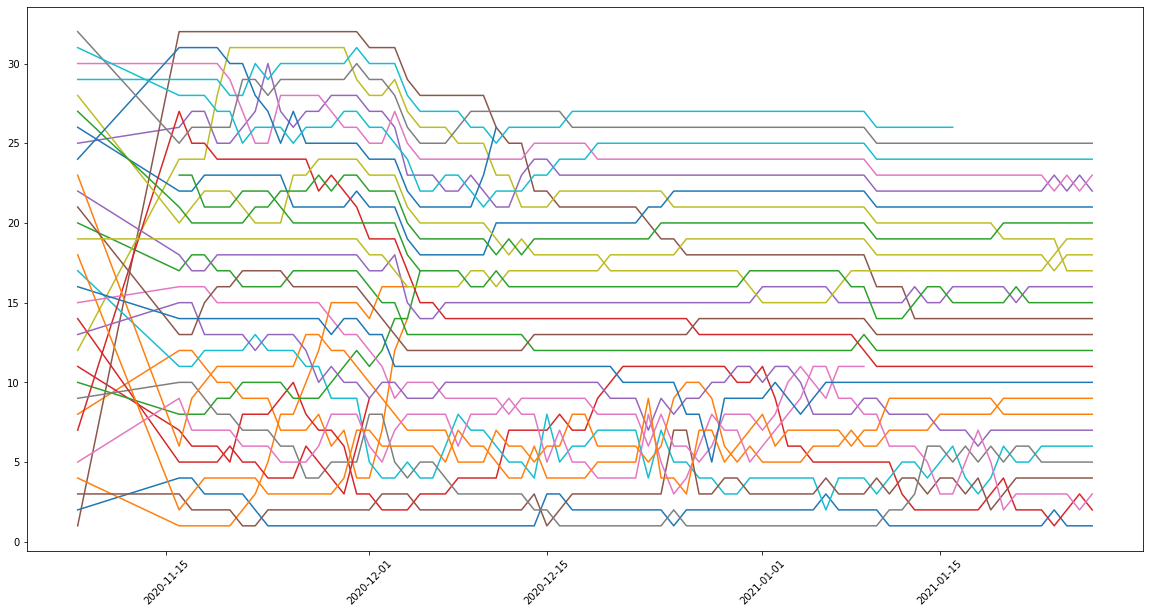

In [38]:
plt.figure(figsize=(20,10))
for voile in df_grouped["Voile"].unique():
    plt.plot(pd.to_datetime(df_grouped[df_grouped["Voile"]==voile]["DateTime"]).dt.date,df_grouped[df_grouped["Voile"]==voile]["Rang"])
plt.xticks(rotation=45)
plt.show()

## Conclusion des visualisations :

Les caractéristiques des navires, et en particulier la présence de foils, semblent avoir une influence sur le rang et la vitesse.

Le classement montre que les rangs se stabilisent assez rapidement et ne fluctuent par la suite que très peu, excepté dans le "peloton de tête". Cela se retrouve dans les figures plotly.

Le Machine Learning nous permettra de défintivement répondre à la question initiale.

*TINTINTIN* 

# MACHINE LEARNING

Nous allons tenter de prédire la différence de rang (ie la progression ou la régression dans le classement) à l'aide de la vitesse depuis le dernier classement. Nous tenterons ensuite de rajouter d'autres "features" à nos modèles de régression, en particulier les caractéristiques des bateaux, afin d'évaluer l'impact du matériel sur la performance.

In [71]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

df_merged["Rangdiff"] = np.nan

for v in df_merged["Voile"].unique():
    mask = df_merged["Voile"]==v
    x = df_merged.loc[mask, :]
    x.iloc[0, -1] = 0
    for i in range(1, len(x)):
        x.iloc[i, -1] = x.iloc[i, 0] - x.iloc[i-1, 0]
    df_merged.loc[mask, :] = x

df_merged["Rangdiff"].isna().mean()

0.0